<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Yeeun-J/blob/master/EECS545_hw5_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/EECS545/hw5/hw5_p2

/content/drive/MyDrive/EECS545/hw5/hw5_p2


My code https://github.com/bjpublic/DeepLearningProject/blob/main/plant_leaf/PART_04_Plant_Leaf_Classification.ipynb

In [3]:
# EECS 545 Fall 2021
# dataset.py
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms


class DogDataset:
    """
    Dog Dataset.
    """
    def __init__(self, batch_size=4, dataset_path='data/images/dogs', if_resize=True):
        self.batch_size = batch_size
        self.dataset_path = dataset_path
        self.if_resize = if_resize
        self.train_dataset = self.get_train_numpy()
        self.x_mean, self.x_std = self.compute_train_statistics()
        self.transform = self.get_transforms()
        self.train_loader, self.val_loader = self.get_dataloaders()

    def get_train_numpy(self):
        train_dataset = torchvision.datasets.ImageFolder(os.path.join(self.dataset_path, 'train'))
        train_x = np.zeros((len(train_dataset), 224, 224, 3))
        
        for i, (img, _) in enumerate(train_dataset):
            train_x[i] = img
        return train_x / 255.0

    def compute_train_statistics(self):
        # TODO (part a): compute per-channel mean and std with respect to self.train_dataset
        x_mean = np.mean(self.train_dataset, axis=(0,1,2))  # per-channel mean
        x_std = np.std(self.train_dataset, axis=(0,1,2))   # per-channel std
        return x_mean, x_std

    def get_transforms(self): #torchvision.transforms
        if self.if_resize:
            # TODO (part a): fill in the data transforms
            transform_list = [
            transforms.Resize((32,32)), # resize the image to 32x32x3
            transforms.ToTensor(), # convert image to PyTorch tensor
            transforms.Normalize(self.x_mean, self.x_std) # normalize the image (use self.x_mean and self.x_std)
        ]
        else: 
            # TODO (part f): fill in the data transforms
            # Note: Only change from part a) is there is no need to resize the image 
            transform_list = [
            transforms.ToTensor(), # convert image to PyTorch tensor
            transforms.Normalize(self.x_mean, self.x_std) # normalize the image (use self.x_mean and self.x_std)
        ]
        transform = transforms.Compose(transform_list)
        return transform

    def get_dataloaders(self):
        # train set
        train_set = torchvision.datasets.ImageFolder(os.path.join(self.dataset_path, 'train'), transform=self.transform)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=self.batch_size, shuffle=True)

        # validation set
        val_set = torchvision.datasets.ImageFolder(os.path.join(self.dataset_path, 'val'), transform=self.transform)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader

    def plot_image(self, image, label):
        image = np.transpose(image.numpy(), (1, 2, 0))
        image = image * self.x_std.reshape(1, 1, 3) + self.x_mean.reshape(1, 1, 3)  # un-normalize
        plt.title(label)
        plt.imshow((image*255).astype('uint8'))
        plt.show()

    def get_semantic_label(self, label):
        mapping = {'chihuahua': 0, 'dalmatian': 1, 'golden_retriever': 2, 'samoyed': 3, 'siberian_husky': 4}
        reverse_mapping = {v: k for k, v in mapping.items()}
        return reverse_mapping[label]


class DogCatDataset:
    """
    Cat vs. Dog Dataset.
    """
    def __init__(self, batch_size=4, dataset_path='data/images/dogs_vs_cats'):
        self.batch_size = batch_size
        self.dataset_path = dataset_path
        self.transform = self.get_transforms()
        self.train_loader, self.val_loader = self.get_dataloaders()

    def get_transforms(self):
        # TODO (part g): fill in the data transforms
        transform_list = [
            transforms.Resize((256,256)),# resize the image to 256x256x3
            transforms.CenterCrop((224,224)),# crop the image at the center of size 224x224x3
            transforms.ToTensor(), # convert image to PyTorch tensor
            transforms.Normalize([0.485,0.456,0.406], [0.229, 0.224, 0.225])# normalize the image
        ]
        transform = transforms.Compose(transform_list)
        return transform

    def get_dataloaders(self):
        # train set
        train_set = torchvision.datasets.ImageFolder(os.path.join(self.dataset_path, 'train'), transform=self.transform)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=self.batch_size, shuffle=True)

        # validation set
        val_set = torchvision.datasets.ImageFolder(os.path.join(self.dataset_path, 'val'), transform=self.transform)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader



In [4]:
dataset = DogDataset()
print(dataset.x_mean, dataset.x_std)
images, labels = iter(dataset.train_loader).next() #returns train loader 

[0.50161345 0.45612671 0.3824407 ] [0.24617303 0.23615181 0.23905821]


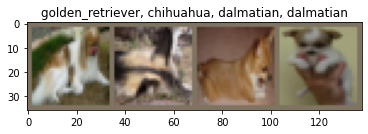

In [5]:
dataset.plot_image(
    torchvision.utils.make_grid(images),
    ', '.join([dataset.get_semantic_label(label.item()) for label in labels]))

In [6]:
# EECS 545 Fall 2021
# model.py
import math
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    """
    Convolutional Neural Network.
    """
    def __init__(self):
        super().__init__()

        # TODO (part c): define layers
        self.conv1 = nn.Conv2d(3, 16, 5, stride=2, padding=2)  # convolutional layer 1
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2, padding=2)  # convolutional layer 2
        self.conv3 = nn.Conv2d(32, 64, 5, stride=2, padding=2)  # convolutional layer 3
        self.conv4 = nn.Conv2d(64, 128, 5, stride=2, padding=2)  # convolutional layer 4
        self.fc1 = nn.Linear(128*2*2,64)  # fully connected layer 1 
        self.fc2 = nn.Linear(64,5)  # fully connected layer 2 (output layer)

        self.init_weights()

    def init_weights(self):
        for conv in [self.conv1, self.conv2, self.conv3, self.conv4]:
            print("conv: ",conv)
            C_in = conv.weight.size(1)
            nn.init.normal_(conv.weight, 0.0, 1 / math.sqrt(5 * 2.5 * C_in)) # 2/(5*5*input)
            nn.init.constant_(conv.bias, 0.0)

        # TODO (part c): initialize parameters for fully connected layers
        for fc in [self.fc1, self.fc2]:
            F_in = fc.weight.size(1)
            nn.init.normal_(fc.weight, 0.0, 1 / math.sqrt(0.5*F_in)) #(tensor, mean, std)#체크하기 !!(F21 변경사항)
            nn.init.constant_(fc.bias, 0.0)

    def forward(self, x):
        N, C, H, W = x.shape

        # TODO (part c): forward pass of image through the network
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = x.view(N, -1)  # flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x) 

        return x #no activation function


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [7]:
from dataset import DogDataset
net = CNN()
print(net)
print('Number of CNN parameters: {}'.format(count_parameters(net)))

conv:  Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
conv:  Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
conv:  Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
conv:  Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)
Number of CNN parameters: 303397


In [24]:
dataset = DogDataset()
images, labels = iter(dataset.train_loader).next()
print('Size of model output:', net(images).size())

Size of model output: torch.Size([4, 5])


In [8]:
# EECS 545 Fall 2021
# train.py
import torch
import numpy as np
import random
import checkpoint
from dataset import DogDataset, DogCatDataset
from model import CNN
from plot import Plotter

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


def predictions(logits):
    """
    Compute the predictions from the model.
    Inputs:
        - logits: output of our model based on some input, tensor with shape=(batch_size, num_classes)
    Returns:
        - pred: predictions of our model, tensor with shape=(batch_size)
    """
    # TODO (part d): compute the predictions
    _, pred = torch.max(logits, 1)
    
    return torch.zeros(logits.size(0))


def accuracy(y_true, y_pred):
    """
    Compute the accuracy given true and predicted labels.
    Inputs:
        - y_true: true labels, tensor with shape=(num_examples)
        - y_pred: predicted labels, tensor with shape=(num_examples)
    Returns:
        - acc: accuracy, float
    """
    # TODO (part d): compute the accuracy
    return (y_pred == y_true).sum().item() / y_true.size(0)


def _train_epoch(train_loader, model, criterion, optimizer):
    """
    Train the model for one iteration through the train set.
    """
    for i, (X, y) in enumerate(train_loader):
        # clear parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()


def _evaluate_epoch(plotter, train_loader, val_loader, model, criterion, epoch):
    """
    Evaluates the model on the train and validation set.
    """
    stat = []
    for data_loader in [val_loader, train_loader]:
        y_true, y_pred, running_loss = evaluate_loop(data_loader, model, criterion)
        total_loss = np.sum(running_loss) / y_true.size(0)
        total_acc = accuracy(y_true, y_pred)
        stat += [total_acc, total_loss]
    plotter.stats.append(stat)
    plotter.log_cnn_training(epoch)
    plotter.update_cnn_training_plot(epoch)


def evaluate_loop(data_loader, model, criterion=None):
    model.eval()
    y_true, y_pred, running_loss = [], [], []
    for X, y in data_loader:
        with torch.no_grad():
            output = model(X)
            predicted = predictions(output.data)
            y_true.append(y)
            y_pred.append(predicted)
            if criterion is not None:
                running_loss.append(criterion(output, y).item() * X.size(0))
    model.train()
    y_true, y_pred = torch.cat(y_true), torch.cat(y_pred)
    return y_true, y_pred, running_loss


def train(config, dataset, model):
    # Data loaders
    train_loader, val_loader = dataset.train_loader, dataset.val_loader

    if 'use_weighted' not in config:
        # TODO (part d): define loss function
        criterion = torch.nn.CrossEntropyLoss()
    else:
        # TODO (part h): define weighted loss function
        criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1., 20.]))
        
    # TODO (part d): define optimizer
    learning_rate = config['learning_rate']
    momentum = config['momentum']
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum )

    # Attempts to restore the latest checkpoint if exists
    print('Loading model...')
    force = config['ckpt_force'] if 'ckpt_force' in config else False
    model, start_epoch, stats = checkpoint.restore_checkpoint(model, config['ckpt_path'], force=force)

    # Create plotter
    plot_name = config['plot_name'] if 'plot_name' in config else 'CNN'
    plotter = Plotter(stats, plot_name)

    # Evaluate the model
    _evaluate_epoch(plotter, train_loader, val_loader, model, criterion, start_epoch)

    # Loop over the entire dataset multiple times
    for epoch in range(start_epoch, config['num_epoch']):
        # Train model on training set
        _train_epoch(train_loader, model, criterion, optimizer)

        # Evaluate model on training and validation set
        _evaluate_epoch(plotter, train_loader, val_loader, model, criterion, epoch + 1)

        # Save model parameters
        checkpoint.save_checkpoint(model, epoch + 1, config['ckpt_path'], plotter.stats)

    print('Finished Training')

    # Save figure and keep plot open
    plotter.save_cnn_training_plot()
    plotter.hold_training_plot()



In [14]:
!python3 dataset.py

[0.50161345 0.45612671 0.3824407 ] [0.24617303 0.23615181 0.23905821]
<Figure size 640x480 with 1 Axes>


In [15]:
!python3 model.py

conv:  Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
conv:  Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
conv:  Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
conv:  Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)
Number of CNN parameters: 303397
Size of model output: torch.Size([4, 5])


In [16]:
!python3 train.py

conv:  Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
conv:  Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
conv:  Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
conv:  Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
Loading model...
No saved model parameters found
Setting up interactive graph...
Epoch 0
	Validation Loss: 1.7692522895641816
	Validation Accuracy: 0.22115384615384615
	Train Loss: 1.7470487117767335
	Train Accuracy: 0.2
<Figure size 1000x500 with 2 Axes>
Epoch 1
	Validation Loss: 1.4260341746684833
	Validation Accuracy: 0.22115384615384615
	Train Loss: 1.2187618803977966
	Train Accuracy: 0.2
Epoch 2
	Validation Loss: 1.415785075762333
	Validation Accuracy: 0.22115384615384615
	Train Loss: 1.0074722006320953
	Train Accuracy: 0.2
Epoch 3
	Validation Loss: 1.2918358620924828
	Validation Accuracy: 0.22115384615384615
	Train Loss: 0.6934608737230301
	Train Accuracy: 0.2
Epoch 4
	Validation Loss: 1.46037

In [ ]:
!python transfer.py

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100% 44.7M/44.7M [00:00<00:00, 48.8MB/s]
Loading model...
No saved model parameters found
Setting up interactive graph...
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch 0
	Validation Loss: 1.5621531040240557
	Validation Accuracy: 0.22115384615384615
	Train Loss: 1.6118454036712646
	Train Accuracy: 0.2
<Figure size 1000x500 with 2 Axes>
Epoch 1
	Validation Loss: 0.2723862174958086
	Validation Accuracy: 0.22115384615384615
	Train Loss: 0.2752694666013122
	Train Accuracy: 0.2
Epoch 2
	Validation Loss: 